In [1]:
# # google colab + google drive sync
# from google.colab import drive
# drive.mount('/content/gdrive/')
# !ls
# %cd gdrive/MyDrive/Colab Notebooks/G-ABC-Infection/AI-Infection-main

# # library install
# !pip install gpytorch
# # requirements.txt file generation
# !pip freeze > requirements.txt

In [2]:
import pandas as pd
import numpy as np
import xlrd
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import os
import random
from gpytorch.mlls import SumMarginalLogLikelihood
from itertools import repeat

In [3]:
## Scenario_1
vac = [0, 42000, 63700]
npi_w = [4, 8, 12]
npi_e = [0.8, 1, 1.2]

In [4]:
# ## Scenario_2
# vac = [0, 20000, 63700]
# npi_w = [4,50,115]
# npi_e = [0.5, 1, 2]

In [5]:
''' fix random seed for reproduce '''
random_seed = 1000
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

데이터 로드 및 전처리

In [6]:
''' data read '''
xls = "../../../../11_data/국제/수집데이터_220227.xlsx"
path_2 = '../../../../11_data/국내/covid19_Nov2.csv'
# path_3 = "../../../../11_data/국내/질병청자료_2020.03.28-2021.12.08.xlsx"
path_3 = "../../../../01_data/AI-Infection/Data/국내/질청공식보도자료/질병청자료_2020.03.02-2022.02.24.xlsx"

x_holiday = pd.read_excel(xls,sheet_name='국가별공휴일',engine = "openpyxl")
x_dist = pd.read_excel(xls,sheet_name='사회적거리두기_Score',engine = "openpyxl")
x_vaccine = pd.read_excel(xls,sheet_name='백신접종자수',engine = "openpyxl")
x_weather = pd.read_excel(xls,sheet_name='국가별수도날씨',engine = "openpyxl")
x_population = pd.read_excel(xls,sheet_name='국가별인구수',engine = "openpyxl")
x_variant = pd.read_excel(xls,sheet_name='변이바이러스 비율',engine = "openpyxl")
y_inspection = pd.read_excel(xls,sheet_name='검사자 데이터 통합',engine = "openpyxl")
y_infection = pd.read_excel(xls,sheet_name='확진자 데이터 통합',engine = "openpyxl")
y_death = pd.read_excel(xls,sheet_name='사망자 데이터 통합',engine = "openpyxl")




In [7]:
print(x_holiday.isnull().sum())
print(x_dist.isnull().sum())
print(x_vaccine.isnull().sum())
print(x_weather.isnull().sum())
print(x_population.isnull().sum())
print(x_variant.isnull().sum())

x_vaccine=x_vaccine.fillna(0)

tDate          0
Country        0
HolidayName    0
dtype: int64
tDate                                       0
Country                                     0
Province                               143166
School_StrIndex                             0
Workplace_StrIndex                          0
CancelPublicEvents_StrIndex                 0
RestrictionsOnGatherings_StrIndex           0
PublicTransport_StrIndex                    0
StayAtHome_StrIndex                         0
RestrictionsOnInternal_StrIndex             0
InternationalTravel_StrIndex                0
PublicInformationCampaigns_StrIndex       636
Stringency_Index                          636
dtype: int64
tDate                       0
Country                     0
PeopleVaccinated            0
PeopleFullyVaccinated    4889
dtype: int64
tDate       0
Country     0
City        0
Temp        0
Humidity    0
Rain        0
Snow        0
dtype: int64
Country           0
Province1        37
Province2       375
PeopleNumber      1
d

In [8]:
start_date = pd.Timestamp('2020-01-01')
# observed_end_date = pd.Timestamp('2021-10-04') # "사망자 데이터 통합"등에 기록된 최종 일자
observed_end_date = pd.Timestamp('2022-02-24') # "사망자 데이터 통합"등에 기록된 최종 일자

end_date = pd.Timestamp('2023-12-31')
date = pd.date_range(start_date,end_date)
country_list = y_inspection.columns.values.tolist()[1:]
country_idx_dict = {key:val for val,key in enumerate(country_list)}

num_country = len(country_list)
td = (end_date - start_date).days + 1 # total date, 2020-01-02 - 2020-01-01 = 1

# GP에 넣기 위한 빈공간 생성
x = np.zeros((6,num_country,td)) # 6: 날짜 + 위 셀에서 불러온 데이터 x 5개 (국가별인구수는 제외)
y = np.zeros((3,num_country,td)) # 3: 검사자, 확진자, 사망자

In [9]:
### 중증자 데이터
_data_sev_1= pd.read_excel(path_3,engine = "openpyxl",usecols = 'A,JG' )
_data_sev_1 = _data_sev_1.drop(index=[0, 1, 2, 3, 4], axis=0)
_data_sev_1 = _data_sev_1.dropna(axis = 0, how = 'any')
_data_sev_1.rename(columns = {'Unnamed: 0' : 'tDate','Unnamed: 266':'Severity'}, inplace = True)
_data_sev_1.reset_index(drop=True, inplace=True)

_data_sev_1

,tDate,Severity
0,2020-07-20,19
1,2020-07-21,21
2,2020-07-22,21
3,2020-07-23,18
4,2020-07-24,16
...,...,...
580,2022-02-20,439
581,2022-02-21,480
582,2022-02-22,480
583,2022-02-23,512


In [10]:
_data_sev_2 = pd.read_csv(path_2,usecols=[0,6])
_data_sev_2

,Date,Severity
0,2020-01-20,0.0
1,2020-01-21,0.0
2,2020-01-22,0.0
3,2020-01-23,0.0
4,2020-01-24,0.0
...,...,...
1072,2022-12-27,NaN
1073,2022-12-28,NaN
1074,2022-12-29,NaN
1075,2022-12-30,NaN


In [11]:
#이유엔데이터 중증자#
data_sev_1 = _data_sev_1
sev_start_date = data_sev_1['tDate'][0]                # 시작 날짜(이전의 데이터를 붙이기 위해 필요)
sev_end_date = data_sev_1['tDate'][len(data_sev_1)-1]  # 끝 날짜 (이후의 데이터를 붙이기 위해 필요)
sev_start_date

Timestamp('2020-07-20 00:00:00')

In [12]:
data_sev_1_2 = data_sev_1.fillna(0)

## 시계열에서 사용한 중증자 초기 데이터 ##2020-01-20~2020-09-14
data_sev_2 = _data_sev_2
data_sev_2['Date'] = pd.to_datetime(data_sev_2['Date'])
old_sev = data_sev_2.loc[data_sev_2['Date']<data_sev_1['tDate'][0]]
old_sev.rename(columns = {'Date' : 'tDate'}, inplace = True)
old_sev_1 = old_sev.fillna(0)
old_sev_1

/home/sysadm/anaconda3/envs/heytrt3.7/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,tDate,Severity
0,2020-01-20,0.0
1,2020-01-21,0.0
2,2020-01-22,0.0
3,2020-01-23,0.0
4,2020-01-24,0.0
...,...,...
177,2020-07-15,0.0
178,2020-07-16,0.0
179,2020-07-17,0.0
180,2020-07-18,0.0


In [13]:
#데이터합치기#
data_sev = pd.concat([old_sev_1,data_sev_1_2],ignore_index=True)
data_sev

,tDate,Severity
0,2020-01-20,0.0
1,2020-01-21,0.0
2,2020-01-22,0.0
3,2020-01-23,0.0
4,2020-01-24,0.0
...,...,...
762,2022-02-20,439.0
763,2022-02-21,480.0
764,2022-02-22,480.0
765,2022-02-23,512.0


In [14]:
# pre_date2 = pd.Timestamp('2020-01-01')          
# end_date2 = pd.Timestamp('2021-10-07')
# train_date2 = pd.date_range(pre_date2,end_date2)    

#y_inspection 프레임에 중증자 데이터를 넣기 
#y_inspection[y_inspection['tDate'].isin(train_date2)]
y_severity  = y_inspection 
# train_date2 = pd.date_range(pre_date2,end_date2)

#1월 20일
for country,country_idx in country_idx_dict.items():
    for i in range(0,len(y_inspection)):
        if i in range(19,19+len(data_sev)): #1월 20일부터데이터가 있으니까 
            y_severity[country][i] = data_sev['Severity'][i-19]
        else:
            y_severity[country][i] = 0

/home/sysadm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/sysadm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
y_death = y_death.loc[y_death['tDate']<=observed_end_date]
y_severity = y_severity.loc[y_severity['tDate']<=observed_end_date]
y_infection = y_infection.loc[y_infection['tDate']<=observed_end_date]

y_severity

,tDate,Australia,Austria,Belgium,Canada,Chile,China,Colombia,Costa Rica,Czechia,...,Slovakia,Slovenia,South Korea,Spain,Sweden,Switzerland,Taiwan,Turkey,United Kingdom,US
0,2020-01-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,2022-02-20,439,439,439,439,439,439,439,439,439,...,439,439,439,439,439,439,439,439,439,439
782,2022-02-21,480,480,480,480,480,480,480,480,480,...,480,480,480,480,480,480,480,480,480,480
783,2022-02-22,480,480,480,480,480,480,480,480,480,...,480,480,480,480,480,480,480,480,480,480
784,2022-02-23,512,512,512,512,512,512,512,512,512,...,512,512,512,512,512,512,512,512,512,512


In [16]:
# 인구수
country_population_dict = {}
for row in x_population.iterrows():
  country, pro1, pro2, num = row[1]
  if type(pro1) == float:
    country_population_dict[country] = num
country_population_dict['Czechia'] = 10650000
country_population_dict['Latvia'] = 1920000
country_population_dict['US'] = 328200000

In [17]:
# 날짜 
# 규칙: 0,1,2,3,4,...
for itr in range(td):
  x[0,:,itr] = itr 

In [18]:
# x_holiday 전처리
# 규칠: 공휴일:1 , 그 외: 0
for row in x_holiday.iterrows():
  current_date, country, _ = row[1]
  idx = (current_date - start_date).days
  if (idx >= 0) and (idx < td) and (country in country_idx_dict):
    x[1,country_idx_dict[country],idx] = 1

In [19]:
# x_dist 전처리
# 규칙: 항목별 score 평균 (province별로 존재할 경우, 이 또한 평균)
country_end_dict = {}
group_x_dist = x_dist.groupby(['tDate', 'Country']).mean() # province별로 존재할 경우, 평균
for row in group_x_dist.iterrows():
  current_date, country = row[0]
  idx = (current_date - start_date).days
  # dist = np.mean(row[1])
  dist = row[1][-1] # Stringency_Index
  if (idx >= 0) and (idx < td) and (country in country_idx_dict):
    if (dist == 0) and (idx>0): # 관측되었지만, 0으로 누락된 경우를 고려하기 위함
      x[2,country_idx_dict[country],idx] = x[2,country_idx_dict[country],idx-1]
    else:
      x[2,country_idx_dict[country],idx] = dist
  country_end_dict[country] = idx

In [20]:
end_social_distance = pd.Timestamp('2022-03-01')
for country,country_end_idx in country_end_dict.items():
  if country == 'South Korea':
      current_date = pd.DateOffset(country_end_idx) + start_date
      social_zero_duration = (end_social_distance - current_date).days # 사회적거리두기 0단계까지 남은 일자
      for itr in range(country_end_idx,td):
        # 한국의 경우, 2022-03-01 기준 사회적거리두기 0으로 만들기 위한 부분 (선형적으로 사회적거리두기 지수 감소)
        x[2,country_idx_dict[country],itr] = np.maximum(0,x[2,country_idx_dict[country],itr] - x[2,country_idx_dict[country],country_end_idx]/social_zero_duration)   
  elif country in country_idx_dict:
    for itr in range(country_end_idx,td):
      x[2,country_idx_dict[country],itr] = x[2,country_idx_dict[country],country_end_idx]

In [21]:
# x_vaccine 전처리
# 규칙: 2차 백신 접종자수만 기록하되, 누적하여 기록 (0으로 결측일 경우, 그 이전 max 값 그대로 가져오기)
# 최신 날짜부터, 2022-12-31까지는 상수로 값 유지
country_end_dict = {}
for row in x_vaccine.iterrows():
  current_date, country, _, num_vaccine = row[1]
  idx = (current_date - start_date).days
  if (idx >= 0) and (idx < td) and (country in country_idx_dict):
    x[3,country_idx_dict[country],idx] = np.maximum(num_vaccine, x[3,country_idx_dict[country],idx-1])
  country_end_dict[country] = idx

In [22]:
# 각 국가별 최신 날짜부터, 2022-12-31까지는 상수로 값 유지
# 대한민국은 주차별 접종시나리오_20210903 반영
# 24주차, 25주차, 26주차, ...
kor_vac_plan = [7181406.69034811,7760371.55489,8027562.416248,8200681.654084,8267810.41448,8420116.203476,8624010.059872,9930437.378528,12108799.243388,13871861.3329597,16697386.518528,17688097.765664,21569072.884204,24477799.079844,25692137.20726,26699005.88246,27167703.95766,28793468.82286,29289075.42806,29289075.42806,29664724.32806,30040373.22806,30416022.12806,30791671.02806,31167319.92806,31542968.82806,31918617.72806,32294266.62806,32669915.52806]
# https://jumin.mois.go.kr/ageStatMonth.do#none
# 60세이상 인구: 12882902
# 40-59: 16793046
# 18-39: 13454265
# 0-19: 8537475
for country,country_end_idx in country_end_dict.items():
    if country == 'South Korea':
      for itr in range(country_end_idx,td):
        current_date = pd.DateOffset(itr) + start_date
        if current_date.year == 2021:
          current_weak = int(current_date.strftime("%V"))
          x[3,country_idx_dict[country],itr] = kor_vac_plan[np.maximum(0,current_weak-24)]
        else:
          x[3,country_idx_dict[country],itr] = x[3,country_idx_dict[country],country_end_idx]
    if country in country_idx_dict:
      for itr in range(country_end_idx,td):
        x[3,country_idx_dict[country],itr] = x[3,country_idx_dict[country],country_end_idx]

In [23]:
# x_weather 전처리
# 규칙: Temp만 기록, city 별로는 평균
# 최신날짜부터, 2021-12-31까지는 1년전 값 유지
group_x_weather = x_weather.groupby(['tDate', 'Country']).mean() # province별로 존재할 경우, 평균
for row in group_x_weather.iterrows():
  current_date, country = row[0]
  idx = (current_date - start_date).days
  temp = row[1][0]
  if (idx >= 0) and (idx < td) and (country in country_idx_dict):
    x[4,country_idx_dict[country],idx] = temp
for itr in range(idx,td):
  x[4,:,itr] = x[4,:,itr-365]

In [24]:
# x_variant 전처리
# 규칙: 21A.Delta 기록
# 최신 날짜부터, 2021-12-31까지는 상수로 값 유지
# 중간 중간 빈 값은, 그 이전 값을 그대로 유지
country_end_dict = {}
prev_idx = 0
for row in x_variant.iterrows():
  country, current_date,variant,_,_,proportion = row[1]
  if variant == '21A.Delta':
    idx = (current_date - start_date).days
    if (idx >= 0) and (idx < td) and (country in country_idx_dict):
      x[5,country_idx_dict[country],prev_idx+1:idx+1] = proportion
    prev_idx = idx
    country_end_dict[country] = idx

# 각 국가별 최신 날짜부터, 2022-12-31까지는 상수로 값 유지
for country,country_end_idx in country_end_dict.items():
  if country in country_idx_dict:
    for itr in range(country_end_idx,td):
      x[5,country_idx_dict[country],itr] = x[5,country_idx_dict[country],country_end_idx]

In [25]:
y_death

,tDate,Australia,Austria,Belgium,Canada,Chile,China,Colombia,Costa Rica,Czechia,...,Slovakia,Slovenia,South Korea,Spain,Sweden,Switzerland,Taiwan,Turkey,United Kingdom,US
0,2020-01-22,-999,-999,-999,-999,-999,0,-999,-999,-999,...,-999,-999,0,-999,-999,-999,0,-999,-999,0
1,2020-01-23,0,-999,-999,-999,-999,0,0,-999,-999,...,-999,-999,0,-999,-999,-999,0,-999,-999,0
2,2020-01-24,-999,-999,-999,-999,-999,9,-999,-999,-999,...,-999,-999,0,-999,-999,-999,0,-999,-999,0
3,2020-01-25,0,-999,-999,-999,-999,16,-999,-999,-999,...,-999,-999,0,-999,-999,-999,0,-999,-999,0
4,2020-01-26,0,-999,-999,0,-999,14,-999,-999,-999,...,-999,-999,0,-999,-999,-999,0,-999,-999,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,2022-02-20,34,0,0,16,129,18,127,0,82,...,24,10,51,0,0,4,0,278,128,630
757,2022-02-21,17,44,0,29,151,12,110,0,38,...,15,19,45,0,0,0,0,263,74,384
758,2022-02-22,37,13,95,5,144,12,99,42,109,...,12,19,58,464,0,16,0,268,31,655
759,2022-02-23,59,37,25,112,35,36,80,18,0,...,27,14,99,173,81,12,0,271,205,3074


In [26]:
# y 전처리
for country,country_idx in country_idx_dict.items():
  if country == 'South Korea':
    ## 없는 데이터...
    y_infection.loc[y_infection['tDate']=='2021-09-25','Confirmed']= 3273
    y_infection.loc[y_infection['tDate']=='2021-10-03','Confirmed']= 2086

    ## 튀는 데이터...
    y_infection.loc[y_infection['tDate']=='2021-09-26','Confirmed']= 2771
    y_infection.loc[y_infection['tDate']=='2021-10-04','Confirmed']= 1673



    ##### 2021-12-17 자 수정
    #### 확진자
    y_infection.loc[y_infection['tDate']=='2021-12-03','Confirmed']= 4944
    y_infection.loc[y_infection['tDate']=='2021-12-04','Confirmed']= 5352
    y_infection.loc[y_infection['tDate']=='2021-12-08','Confirmed']= 7175

    #### 사망자
    y_death.loc[y_death['tDate']=='2021-12-03','Deaths']= 34
    y_death.loc[y_death['tDate']=='2021-12-04','Deaths']= 70
    y_death.loc[y_death['tDate']=='2021-12-08','Deaths']= 63
    
  country_severity = y_severity[country]
  country_infection = y_infection[country]
  country_death = y_death[country]

  y[0,country_idx,:len(country_severity)] = country_severity # from 2020-01-01
  y[1,country_idx,21:21+len(country_infection)] = country_infection # from 2020-01-22
  y[2,country_idx,21:21+len(country_death)] = country_death # from 2020-01-22

In [27]:
# y_infection.loc[y_infection['tDate']=='2021-10-03','Confirmed']

In [28]:
# x 최종 전처리 (0~1사이의 범위로 변경)
x[0,:,:] = x[0,:,:]/td # 날짜
x[1,:,:] = x[1,:,:] # 그대로 0,1
x[2,:,:] = x[2,:,:]/100 # 거리두기 score
for country,country_idx in country_idx_dict.items():
  x[3,country_idx,:] = x[3,country_idx,:]/country_population_dict[country] # vaccine
x[4,:,:] = x[4,:,:]/np.max(x[4,:,:]) # weather
x[5,:,:] = x[5,:,:] # variant

In [29]:
# y 최종 전처리 (0~1사이의 범위로 변경)
max_list = []
for country,country_idx in country_idx_dict.items():
  max_list.append([np.max(y[0,country_idx,:]),np.max(y[1,country_idx,:]),np.max(y[2,country_idx,:])])
  y[0,country_idx,:] = y[0,country_idx,:]/np.max(y[0,country_idx,:]) # inspection
  y[1,country_idx,:] = y[1,country_idx,:]/np.max(y[1,country_idx,:]) # infection
  y[2,country_idx,:] = y[2,country_idx,:]/np.max(y[2,country_idx,:]) # death
  # y[0,country_idx,:] = y[0,country_idx,:]/country_population_dict[country] # inspection
  # y[1,country_idx,:] = y[1,country_idx,:]/country_population_dict[country] # infection
  # y[2,country_idx,:] = y[2,country_idx,:]/country_population_dict[country] # death

In [30]:
# df = pd.DataFrame(x[0,:,:])
# df.to_csv('x_date.csv',index=False)

# df = pd.DataFrame(x[1,:,:])
# df.to_csv('x_holiday.csv',index=False)

# df = pd.DataFrame(x[2,:,:])
# df.to_csv('x_dist.csv',index=False)

# df = pd.DataFrame(x[3,:,:])
# df.to_csv('x_vaccine.csv',index=False)

# df = pd.DataFrame(x[4,:,:])
# df.to_csv('x_weather.csv',index=False)

# df = pd.DataFrame(x[5,:,:])
# df.to_csv('x_variant.csv',index=False)

In [31]:
# np.savetxt('x.csv',x,delimiter=",")
# np.savetxt("x.csv", array.reshape((3,-1)), fmt="%s")

In [32]:
# numpy to pytorch tensor
torch_x = torch.from_numpy(x).float()
torch_y = torch.from_numpy(y).float()
print(x.shape,y.shape,torch.max(torch_x),torch.max(torch_y[2,:,:]))

(6, 40, 1461) (3, 40, 1461) tensor(nan) tensor(1.)


In [33]:
# df = pd.DataFrame(torch_x)
# df.to_csv('torch_x.csv',index=False)

In [34]:
# train, test split
start_point = (pd.Timestamp('2020-09-01') - start_date).days # we remove data before 2020-09-01, many values are one or zero
# start_point = 366 # 2021-01-01 0~29: many values are one or zero
end_point = (observed_end_date-start_date).days

train_date = date[start_point:end_point]
train_x = torch_x[:,:,start_point:end_point]
train_y = torch_y[:,:,start_point:end_point]

test_date = date[end_point:]
test_x = torch_x[:,:,end_point:]
test_y = torch_y[:,:,end_point:]

print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)

torch.Size([6, 40, 541]) torch.Size([6, 40, 676]) torch.Size([3, 40, 541]) torch.Size([3, 40, 676])


In [35]:
# df = pd.DataFrame(train_x)
# df.to_csv('train_x.csv',index=False)

In [36]:
data_dim = train_x.size(0)
feature_dim = 10
class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(data_dim, 64))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(64, 32))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(32, feature_dim))

feature_extractor = LargeFeatureExtractor()

In [37]:
# initialize model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()+gpytorch.kernels.PeriodicKernel() + gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=10)*gpytorch.kernels.PeriodicKernel()+gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()+gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()*gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel()*gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=feature_dim)*gpytorch.kernels.PeriodicKernel()+gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()*gpytorch.kernels.PeriodicKernel()*gpytorch.kernels.LinearKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()*gpytorch.kernels.PeriodicKernel()*gpytorch.kernels.LinearKernel())
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=feature_dim))
        # self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=3,ard_num_dims=feature_dim)
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)
        self.feature_extractor = feature_extractor

    def forward(self, x):
        projected_x = self.feature_extractor(x)
        projected_x = self.scale_to_bounds(projected_x)
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [38]:
# initialize likelihood
model_list = []
likelihood_list = []
num_country = len(country_idx_dict)
'''
한국, 영국, 미국에 대해서 multi-output gp
'''
target_country_list = [32,38,39] # South Korea, United Kingdom, UK
for mode_itr in [0,1,2]: # 1: infection', 2: death
  for itr in range(num_country):
    if itr in target_country_list:
      likelihood = gpytorch.likelihoods.GaussianLikelihood()
      model = ExactGPModel(train_x[:,itr,:].T, train_y[mode_itr,itr,:], likelihood)
      model_list.append(model)
      likelihood_list.append(model.likelihood)

In [39]:
model = gpytorch.models.IndependentModelList(*model_list)
likelihood = gpytorch.likelihoods.LikelihoodList(*likelihood_list)

In [40]:
# Use the adam optimizer
# 0.01 / 700
training_iter = 500
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

In [41]:
# training
model.train()
likelihood.train()

# "Loss" for GPs - the marginal log likelihood
mll = SumMarginalLogLikelihood(likelihood, model)
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(*model.train_inputs)
    loss = -mll(output, model.train_targets)
    loss.backward()
    optimizer.step()
    if i%10 == 0:
      print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))

Iter 1/500 - Loss: 0.760
Iter 11/500 - Loss: 0.719
Iter 21/500 - Loss: 0.682
Iter 31/500 - Loss: 0.644
Iter 41/500 - Loss: 0.605
Iter 51/500 - Loss: 0.566
Iter 61/500 - Loss: 0.525
Iter 71/500 - Loss: 0.483
Iter 81/500 - Loss: 0.440
Iter 91/500 - Loss: 0.397
Iter 101/500 - Loss: 0.354
Iter 111/500 - Loss: 0.308
Iter 121/500 - Loss: 0.263
Iter 131/500 - Loss: 0.218
Iter 141/500 - Loss: 0.172
Iter 151/500 - Loss: 0.125
Iter 161/500 - Loss: 0.078
Iter 171/500 - Loss: 0.031
Iter 181/500 - Loss: -0.016
Iter 191/500 - Loss: -0.062
Iter 201/500 - Loss: -0.104
Iter 211/500 - Loss: -0.155
Iter 221/500 - Loss: -0.204
Iter 231/500 - Loss: -0.251
Iter 241/500 - Loss: -0.297
Iter 251/500 - Loss: -0.342
Iter 261/500 - Loss: -0.386
Iter 271/500 - Loss: -0.436
Iter 281/500 - Loss: -0.480
Iter 291/500 - Loss: -0.514
Iter 301/500 - Loss: -0.564
Iter 311/500 - Loss: -0.607
Iter 321/500 - Loss: -0.649
Iter 331/500 - Loss: -0.693
Iter 341/500 - Loss: -0.716
Iter 351/500 - Loss: -0.764
Iter 361/500 - Loss: 

In [42]:
# testing
concat_train_x = []
concat_test_x = []
for mode_itr in [0,1,2]:
  for itr in range(num_country):
    if itr in target_country_list:
      concat_train_x.append(train_x[:,itr,:].T)
      concat_test_x.append(test_x[:,itr,:].T)

model.eval()
likelihood.eval()
estimations = likelihood(*model(*concat_train_x))
predictions = likelihood(*model(*concat_test_x))

/home/sysadm/anaconda3/envs/heytrt3.7/lib/python3.6/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


In [43]:
def plot_figure(target_country,mode):
  target_country_population = country_population_dict[target_country]
  if mode == 0:
    name = 'Severity'
    if target_country == 'South Korea':
      data = y_severity
      target_country_idx = 0
      y_lim = [-300,2000]
    elif target_country == 'United Kingdom':
      target_country_idx = 1
      y_lim = [-1000,80000]
    elif target_country == 'US':
      target_country_idx = 2
      y_lim = [-1000,450000]
  elif mode == 1:
    name = 'Infection'
    if target_country == 'South Korea':
      target_country_idx = 3
      y_lim = [-1000,100000]
    elif target_country == 'United Kingdom':
      target_country_idx = 4
      y_lim = [-1000,100000]
    elif target_country == 'US':
      target_country_idx = 5
      y_lim = [-1000,450000]
  elif mode == 2:
    name = 'death'
    if target_country == 'South Korea':
      target_country_idx = 6
      y_lim = [-10,500]
    elif target_country == 'United Kingdom':
      target_country_idx = 7
      y_lim = [-1000,3000]
    elif target_country == 'US':
      target_country_idx = 8
      y_lim = [-1666,5000]

  submodel = model.models[target_country_idx]
  estimation = estimations[target_country_idx]
  prediction = predictions[target_country_idx]
  max_value = max_list[country_idx_dict[target_country]][mode]

  lower, upper = prediction.confidence_region()
  tr_x = submodel.train_inputs[0].detach().numpy()[:,0]
  tr_y = submodel.train_targets.detach().numpy()
  # Plot training data as black stars
  plt.plot(tr_x, tr_y*max_value, 'k*')

  # Predictive mean as blue line
  plt.plot(train_x[0,country_idx_dict[target_country],:].numpy(), estimation.mean.numpy()*max_value, 'b')
  plt.plot(test_x[0,country_idx_dict[target_country],:].numpy(), prediction.mean.numpy()*max_value, 'r')

  # Shade in confidence
  plt.fill_between(test_x[0,country_idx_dict[target_country],:].numpy(), 
                    lower.detach().numpy()*max_value, 
                    upper.detach().numpy()*max_value, alpha=0.5)
  plt.ylim(y_lim)
  plt.legend(['Observed Data', 'Mean', 'Confidence'])
  plt.title('Observed Values (Likelihood)')
  plt.legend(['Ground-Truth', 'Estimation', 'Prediction'])
  plt.ylabel(name)

  new_date = date[start_point:].to_numpy()
  y_loc = y_lim[0]*1.5

  plt.xticks([0.155,0.44,1.0], [str(new_date[int(len(new_date)*0.0)])[:10],
                                  str(new_date[end_point-start_point])[:10],
                                  str(end_date)[:10]],rotation=45,fontsize=10)

  plt.tight_layout()
#   plt.savefig("results/"+str(target_country)+'_'+str(name),dpi=300)
  plt.show()

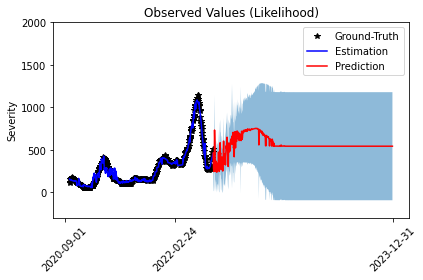

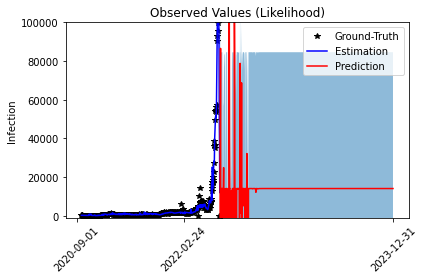

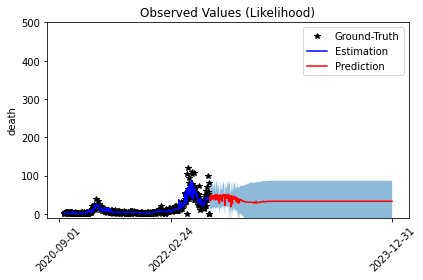

In [44]:
# visualization
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  target_country_list = ['South Korea']
  mode_list = [0,1,2] # 1: infection', 2: death

  for target_country in target_country_list:
    for mode in mode_list: 
      plot_figure(target_country,mode)